In [ ]:
import sys
sys.path.append('../')
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from model import Net, MCMC
from torch.utils.data import DataLoader, SequentialSampler
from tqdm import tqdm
from torch.optim import Adam

In [2]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(), transforms.GaussianBlur(kernel_size=11, sigma=(5, 7)),  # Stronger blur
    transforms.Lambda(lambda x: torch.flatten(x)),
])

In [3]:
dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                       transform=transform)


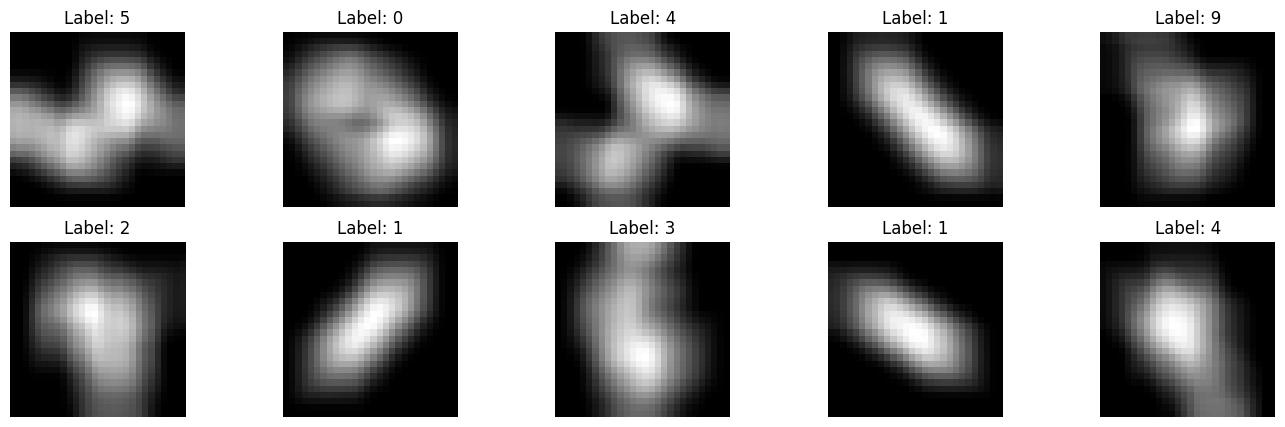

In [4]:
num_images = 10

# Plot multiple images
fig, axes = plt.subplots(2, num_images // 2, figsize=(17, 5))

for i in range(num_images):
    image, label = dataset1[i]  # Get image and label
    image_np = image.reshape(28, 28).squeeze().numpy()  # Convert to NumPy

    ax = axes[i // (num_images // 2), i % (num_images // 2)]
    ax.imshow(image_np, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

In [5]:
BATCH_SIZE = 32
EPOCHS = 6
NUM_MASKS = 1
LR = 0.01

In [6]:
seed = 42
torch.manual_seed(seed)
train_dataloader = DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset2)

### Overfitting portion (make dropout probabilites 0 to indicates fully connected)

In [7]:
model = Net(num_masks=NUM_MASKS, dropout_probs=[0])
opt = Adam(model.parameters(), lr=LR)
lossFn = torch.nn.NLLLoss() # Use NLL since we our model is outputting a probability


In [8]:
for i in range(EPOCHS):
    model.train()
    trainCorrect = 0
    totalLoss = 0
    for idx, (x, y)  in tqdm(enumerate(train_dataloader)):
        logits = model.forward(x, mask = idx % NUM_MASKS)
        loss = lossFn(logits, y)
        totalLoss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        trainCorrect += (logits.argmax(1) == y).type(
			torch.float).sum().item()
    print(f"Train Accuracy: {trainCorrect/len(dataset1)}")
    print(f"Total loss: {totalLoss}")

0it [00:00, ?it/s]

1875it [00:10, 184.53it/s]


Train Accuracy: 0.48973333333333335
Total loss: 2625.097766518593


1875it [00:09, 199.37it/s]


Train Accuracy: 0.6134666666666667
Total loss: 2104.6142852902412


1875it [00:09, 202.38it/s]


Train Accuracy: 0.6456166666666666
Total loss: 1962.0396873056889


1875it [00:09, 199.06it/s]


Train Accuracy: 0.6724833333333333
Total loss: 1844.8827154934406


1875it [00:09, 195.47it/s]


Train Accuracy: 0.67975
Total loss: 1811.962212562561


1875it [00:09, 194.96it/s]

Train Accuracy: 0.68285
Total loss: 1790.908489704132


In [9]:
test_correct = 0
model.eval()
for idx, (x, y)  in tqdm(enumerate(test_dataloader)):
    logits = model.forward(x, mask=1)
    pred = torch.argmax(logits, dim=1)
    test_correct += (pred == y).sum().item()
print(test_correct / len(dataset2))

10000it [00:02, 4589.25it/s]

0.7112
